[View in Colaboratory](https://colab.research.google.com/github/nuass/deeplearn/blob/master/ok_LeNet_5for_mnist.ipynb)

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [8]:
!pip install tensorflow-serving-api

  Could not find a version that satisfies the requirement tensorflow-serving-api (from versions: )
No matching distribution found for tensorflow-serving-api


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
#!kill -9 -1 ##reset the project

In [0]:
#!cd drive/app
#!ls drive/app/MNIST_model_LeNet

问题：interface只可以执行一次会报错 Variable layer1-conv1/weight already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:
 Variable layer1-conv1/weight already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:。。
 原因是the graph (with it's layer names) already exists
解决办法：add`  tf.reset_default_graph()` at the beginning of the block

参数：epoch

In [23]:
#@title 默认标题文本
%%writefile inference.py
import  tensorflow  as tf

INPUT_NODE = 784
OUTPUT_NODE = 10

IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 10

CONV1_DEEP = 32
CONV1_SIZE = 5

CONV2_DEEP = 64
CONV2_SIZE = 5

FC_SIZE = 512
#tf.reset_default_graph()
def inference(input_tensor, train, regularizer):
    with tf.variable_scope('layer1-conv1'):
        conv1_weights = tf.get_variable(
            "weight", [CONV1_SIZE, CONV1_SIZE, NUM_CHANNELS, CONV1_DEEP],
            initializer=tf.truncated_normal_initializer(stddev=0.1))
        conv1_biases = tf.get_variable("bias", [CONV1_DEEP], initializer=tf.constant_initializer(0.0))
        conv1 = tf.nn.conv2d(input_tensor, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))

    with tf.name_scope("layer2-pool1"):
        pool1 = tf.nn.max_pool(relu1, ksize = [1,2,2,1],strides=[1,2,2,1],padding="SAME")

    with tf.variable_scope("layer3-conv2"):
        conv2_weights = tf.get_variable(
            "weight", [CONV2_SIZE, CONV2_SIZE, CONV1_DEEP, CONV2_DEEP],
            initializer=tf.truncated_normal_initializer(stddev=0.1))
        conv2_biases = tf.get_variable("bias", [CONV2_DEEP], initializer=tf.constant_initializer(0.0))
        conv2 = tf.nn.conv2d(pool1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))

    with tf.name_scope("layer4-pool2"):
        pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        pool_shape = pool2.get_shape().as_list()
             
        nodes = pool_shape[1] * pool_shape[2] * pool_shape[3]
        reshaped = tf.reshape(pool2, [pool_shape[0], nodes])

    with tf.variable_scope('layer5-fc1'):
        fc1_weights = tf.get_variable("weight", [nodes, FC_SIZE],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer != None: tf.add_to_collection('losses', regularizer(fc1_weights))
        fc1_biases = tf.get_variable("bias", [FC_SIZE], initializer=tf.constant_initializer(0.1))

        fc1 = tf.nn.relu(tf.matmul(reshaped, fc1_weights) + fc1_biases)
        if train: fc1 = tf.nn.dropout(fc1, 0.5)

    with tf.variable_scope('layer6-fc2'):
        fc2_weights = tf.get_variable("weight", [FC_SIZE, NUM_LABELS],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer != None: tf.add_to_collection('losses', regularizer(fc2_weights))
        fc2_biases = tf.get_variable("bias", [NUM_LABELS], initializer=tf.constant_initializer(0.1))
        logit = tf.matmul(fc1, fc2_weights) + fc2_biases

    return logit

Overwriting inference.py


In [0]:
exec(open('inference.py').read())##引用inference

In [0]:

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import inference
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
#BATCH_SIZE = 100
#LEARNING_RATE_BASE = 0.01
LEARNING_RATE_DECAY = 0.99
REGULARIZATION_RATE = 0.0001
#TRAINING_STEPS = 6000
MOVING_AVERAGE_DECAY = 0.99
MODEL_SAVE_PATH="drive/app/MNIST_model_LeNet/"
MODEL_NAME="LeNet_model"
ls_step=[]
ls_loss=[]
def train(mnist):
    # 定义输出为4维矩阵的placeholder
    x = tf.placeholder(tf.float32, [
            BATCH_SIZE,
            inference.IMAGE_SIZE,
            inference.IMAGE_SIZE,
            inference.NUM_CHANNELS],
        name='x-input')
    y_ = tf.placeholder(tf.float32, [None, inference.OUTPUT_NODE], name='y-input')
    
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    y = inference.inference(x,False,regularizer)####??
   
    global_step = tf.Variable(0, trainable=False)

    # 定义损失函数、学习率、滑动平均操作以及训练过程。
    variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=tf.argmax(y_, 1))
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
    learning_rate = tf.train.exponential_decay(
        LEARNING_RATE_BASE,
        global_step,
        mnist.train.num_examples / BATCH_SIZE, LEARNING_RATE_DECAY,
        staircase=True)

    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    with tf.control_dependencies([train_step, variables_averages_op]):
        train_op = tf.no_op(name='train')
        
    # 初始化TensorFlow持久化类。
    saver = tf.train.Saver()

   
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in range(TRAINING_STEPS):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)

            reshaped_xs = np.reshape(xs, (
                BATCH_SIZE,
                inference.IMAGE_SIZE,
                inference.IMAGE_SIZE,
                inference.NUM_CHANNELS))
            _, loss_value, step = sess.run([train_op, loss, global_step], feed_dict={x: reshaped_xs, y_: ys})

            if ((i+1) % 1000 == 0):
                print("After %d training step(s), loss on training batch is %g." % (step, loss_value))
                saver.save(sess, os.path.join(MODEL_SAVE_PATH, MODEL_NAME), global_step=global_step)
                ls_step.append(step)
                ls_loss.append(loss_value)
     
        plt.xlabel("step")
        plt.ylabel("loss")
        plt.title("train")

        plt.plot(ls_step,ls_loss,label = 'training step %s'%TRAINING_STEPS)
        plt.legend()
        plt.show()
                
                
                


##根据参数类型不同，可以定义字符串DEFINE_string，可以定义整数DEFINE_integer



```
# 此内容为代码格式
tf.app.flags.DEFINE_integer('batch_size', 100, 'batch size')
tf.app.flags.DEFINE_float('learning_rate', 0.1, 'l;earning rate')
tf.app.flags.DEFINE_integer('epoch', 1000, 'how many epoch tf will run')
tf.app.flags.DEFINE_string('ckp_dir', 'C:\\tmp\\d44', 'where to save tensorboard')
```





In [0]:
#@title 参数 { form-width: "40%", display-mode: "form" }
BATCH_SIZE = 100 #@param {type:"integer"}
TRAINING_STEPS = 10000 #@param {type:"integer"}
LEARNING_RATE_BASE = 0.1 #@param {type:"number"}

def main(argv=None):
    mnist = input_data.read_data_sets("drive/data/mnist_data", one_hot=True)
    tf.reset_default_graph()
    train(mnist)
    

if __name__ == '__main__':
    main()

Extracting drive/data/mnist_data/train-images-idx3-ubyte.gz
Extracting drive/data/mnist_data/train-labels-idx1-ubyte.gz
Extracting drive/data/mnist_data/t10k-images-idx3-ubyte.gz
Extracting drive/data/mnist_data/t10k-labels-idx1-ubyte.gz
After 1000 training step(s), loss on training batch is 0.760762.
After 2000 training step(s), loss on training batch is 0.643814.
After 3000 training step(s), loss on training batch is 0.591714.
After 4000 training step(s), loss on training batch is 0.583592.


##验证集-Validation
准确率达到98.9


Extracting drive/data/mnist_data/train-images-idx3-ubyte.gz
Extracting drive/data/mnist_data/train-labels-idx1-ubyte.gz
Extracting drive/data/mnist_data/t10k-images-idx3-ubyte.gz
Extracting drive/data/mnist_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from drive/app/MNIST_model_LeNet/LeNet_model-1000
After drive/app/MNIST_model_LeNet/LeNet_model-1000 training step(s), validation accuracy = 0.9862
INFO:tensorflow:Restoring parameters from drive/app/MNIST_model_LeNet/LeNet_model-2000
After drive/app/MNIST_model_LeNet/LeNet_model-2000 training step(s), validation accuracy = 0.9906
INFO:tensorflow:Restoring parameters from drive/app/MNIST_model_LeNet/LeNet_model-3000
After drive/app/MNIST_model_LeNet/LeNet_model-3000 training step(s), validation accuracy = 0.9906
INFO:tensorflow:Restoring parameters from drive/app/MNIST_model_LeNet/LeNet_model-4000
After drive/app/MNIST_model_LeNet/LeNet_model-4000 training step(s), validation accuracy = 0.9906
INFO:tensorflow:Restor

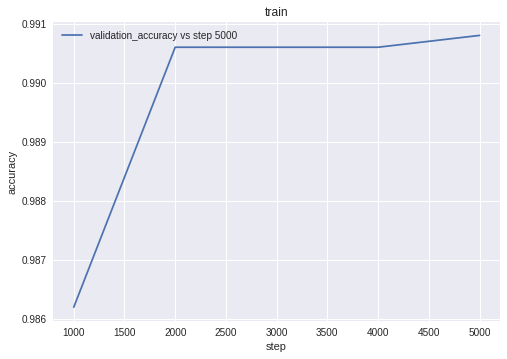

In [20]:
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import inference

# 加载的时间间隔。
EVAL_INTERVAL_SECS = 10
ls_accuracy=[]
def evaluate(mnist):
    with tf.Graph().as_default() as g:
        x = tf.placeholder(tf.float32, [
            mnist.validation.num_examples,
            inference.IMAGE_SIZE,
            inference.IMAGE_SIZE,
            inference.NUM_CHANNELS],
        name='x-input')
        y_ = tf.placeholder(tf.float32, [None, inference.OUTPUT_NODE], name='y-input')
        reshaped_xs = np.reshape(mnist.validation.images,[
                -1,
                inference.IMAGE_SIZE,
                inference.IMAGE_SIZE,
                inference.NUM_CHANNELS])
        validate_feed = {x: reshaped_xs, y_: mnist.validation.labels}
        y = inference.inference(x, False,None)
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)

        #while True:
        with tf.Session() as sess:
            ckpt = tf.train.get_checkpoint_state(MODEL_SAVE_PATH)
           
            if ckpt and ckpt.all_model_checkpoint_paths:
              for model_step in ckpt.all_model_checkpoint_paths:
                saver.restore(sess, model_step)
                accuracy_score = sess.run(accuracy, feed_dict=validate_feed)
                ls_accuracy.append(accuracy_score)
               
                print("After %s training step(s), validation accuracy = %g" % (model_step, accuracy_score))
            else:
                print('No checkpoint file found')
                return
         #   time.sleep(EVAL_INTERVAL_SECS)
        plt.xlabel("step")
        plt.ylabel("accuracy")
        plt.title("train")

        plt.plot(ls_step,ls_accuracy,label = 'validation_accuracy vs step %s'%TRAINING_STEPS)
    
        plt.legend()
        plt.show()
                
def main(argv=None):
    mnist = input_data.read_data_sets("drive/data/mnist_data", one_hot=True)
    evaluate(mnist)

if __name__ == '__main__':
    main()

Extracting drive/data/mnist_data/train-images-idx3-ubyte.gz
Extracting drive/data/mnist_data/train-labels-idx1-ubyte.gz
Extracting drive/data/mnist_data/t10k-images-idx3-ubyte.gz
Extracting drive/data/mnist_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from drive/app/MNIST_model_LeNet/LeNet_model-1000
After drive/app/MNIST_model_LeNet/LeNet_model-1000 training step(s), validation accuracy = 0.9839
INFO:tensorflow:Restoring parameters from drive/app/MNIST_model_LeNet/LeNet_model-2000
After drive/app/MNIST_model_LeNet/LeNet_model-2000 training step(s), validation accuracy = 0.9877
INFO:tensorflow:Restoring parameters from drive/app/MNIST_model_LeNet/LeNet_model-3000
After drive/app/MNIST_model_LeNet/LeNet_model-3000 training step(s), validation accuracy = 0.9893
INFO:tensorflow:Restoring parameters from drive/app/MNIST_model_LeNet/LeNet_model-4000
After drive/app/MNIST_model_LeNet/LeNet_model-4000 training step(s), validation accuracy = 0.9906
INFO:tensorflow:Restor

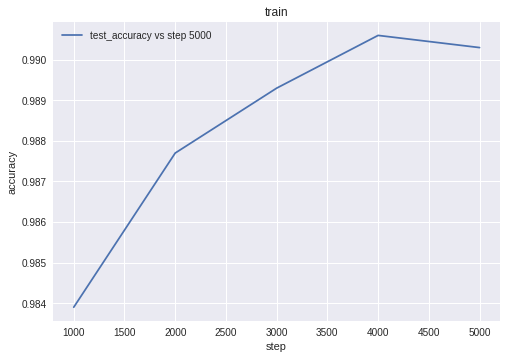

In [21]:
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import inference

# 加载的时间间隔。
EVAL_INTERVAL_SECS = 10
ls_accuracy_test=[]
def evaluate(mnist):
    with tf.Graph().as_default() as g:
        x = tf.placeholder(tf.float32, [
            mnist.test.num_examples,
            inference.IMAGE_SIZE,
            inference.IMAGE_SIZE,
            inference.NUM_CHANNELS],
        name='x-input')
        y_ = tf.placeholder(tf.float32, [None, inference.OUTPUT_NODE], name='y-input')
        reshaped_xs = np.reshape(mnist.test.images,[
                -1,
                inference.IMAGE_SIZE,
                inference.IMAGE_SIZE,
                inference.NUM_CHANNELS])
        test_feed = {x: reshaped_xs, y_: mnist.test.labels}
        y = inference.inference(x, False,None)
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)

        #while True:
        with tf.Session() as sess:
            ckpt = tf.train.get_checkpoint_state(MODEL_SAVE_PATH)
            if ckpt and ckpt.all_model_checkpoint_paths:
              for model_step in ckpt.all_model_checkpoint_paths:
                saver.restore(sess, model_step)
                accuracy_score = sess.run(accuracy, feed_dict=test_feed)
                ls_accuracy_test.append(accuracy_score)
               
                print("After %s training step(s), validation accuracy = %g" % (model_step, accuracy_score))
            else:
                print('No checkpoint file found')
                return
         #   time.sleep(EVAL_INTERVAL_SECS)
        plt.xlabel("step")
        plt.ylabel("accuracy")
        plt.title("train")

        plt.plot(ls_step,ls_accuracy_test,label = 'test_accuracy vs step %s'%TRAINING_STEPS)
    
        plt.legend()
        plt.show()
                
def main(argv=None):
    mnist = input_data.read_data_sets("drive/data/mnist_data", one_hot=True)
    evaluate(mnist)

if __name__ == '__main__':
    main()